In [1]:
from matplotlib import pyplot as plt
from src.datasets.Nii_Gz_Dataset_3D import Dataset_NiiGz_3D
from src.datasets.Nii_Gz_Dataset_3D_customPath import Dataset_NiiGz_3D_customPath
from src.models.Model_M3DNCA import M3DNCA
from src.agents.Agent_M3DNCA_Simple import M3DNCAAgent
from src.losses.LossFunctions import DiceFocalLoss
from src.utils.Study import Study
from src.utils.ProjectConfiguration import ProjectConfiguration
from src.utils.BaselineConfigs import EXP_OctreeNCA3D, EXP_UNet2D, EXP_M3DNCA, EXP_TransUNet, EXP_MEDNCA, EXP_OctreeNCA, EXP_BasicNCA
from src.datasets.png_seg_Dataset import png_seg_Dataset
from src.datasets.Nii_Gz_Dataset import Nii_Gz_Dataset
import octree_vis, os, torch
from src.utils.ProjectConfiguration import ProjectConfiguration
ProjectConfiguration.STUDY_PATH = r"/local/scratch/clmn1/octree_study/"

import inspect
import random
from src.models.Model_OctreeNCA_3d_patching import Octree3DNoStates
import numpy as np
import matplotlib.pyplot as plt

/home/nlemke/remote/miniconda3/envs/nca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
study_config = {
        'img_path': r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTr/",
        'label_path': r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTr/",
        'name': r'Prostate25',
        'device':"cuda:0",
        'unlock_CPU': True,
        # Optimizer
        'lr_gamma': 0.9999,
        'betas': (0.9, 0.99),
        # Training
        'save_interval': 10,
        'evaluate_interval': 10,
        'n_epoch': 1500,
        # Model
        'input_channels': 1,
        'output_channels': 1,
        'hidden_size': 64,
        'train_model':1,
        'channel_n': 16,
        'kernel_size': [3, 5, 7, 3, 3],
        # Data
        'input_size': [(320, 320, 24)], # (320, 320, 24) -> (160, 160, 12) -> (80, 80, 12) -> (40, 40, 12) -> (20, 20, 12)
        
        'data_split': [1.0, 0, 0.0], 
        'keep_original_scale': False,
        'rescale': True,
        # Octree - specific
        'octree_res_and_steps': [((320,320,24), 40), ((160,160,12), 0), ((80,80,6), 20), ((40,40,6), 0), ((20,20,6), 0)],
        'separate_models': True,
        # (160, 160, 12) <- (160, 160, 12) <- (80, 80, 12) <- (40, 40, 12) <- (20, 20, 12)
        'patch_sizes':[((160, 160, 6)), None, None, None, None],
        #'patch_sizes': [None] *5,
        ### TEMP
        

        'compile': False,
        'batch_size': 4,
        'batch_duplication': 2,
    }
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.autograd.set_detect_anomaly(True)
study = Study(study_config)
dataset = Dataset_NiiGz_3D()
exp = EXP_OctreeNCA3D().createExperiment(study_config, detail_config={}, dataset=dataset)
study.add_experiment(exp)

hyp99_test = Dataset_NiiGz_3D_customPath(resize=True, size=(320, 320, 24), imagePath=r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTs", labelPath=r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTs")
hyp99_test.exp = exp
study.my_custom_evaluation_set = hyp99_test
def evaluate():
    print("RUNNING CUSTOM EVALUATION")

    exp.agent.getAverageDiceScore(pseudo_ensemble=True, dataset=study.my_custom_evaluation_set)

study.eval_experiments = evaluate

DATA INSTANCE CREATED
CONFIG {'description': 'OctreeNCA3D', 'lr': 0.0016, 'batch_duplication': 2, 'channel_n': 16, 'inference_steps': 64, 'cell_fire_rate': 0.5, 'batch_size': 4, 'hidden_size': 64, 'train_model': 1, 'betas': (0.9, 0.99), 'kernel_size': [3, 5, 7, 3, 3], 'scale_factor': 4, 'levels': 2, 'input_size': [(320, 320, 24)], 'img_path': '/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTr/', 'label_path': '/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTr/', 'name': 'Prostate25', 'device': 'cuda:0', 'unlock_CPU': True, 'lr_gamma': 0.9999, 'save_interval': 10, 'evaluate_interval': 10, 'n_epoch': 1500, 'input_channels': 1, 'output_channels': 1, 'data_split': [1.0, 0, 0.0], 'keep_original_scale': False, 'rescale': True, 'octree_res_and_steps': [((320, 320, 24), 40), ((160, 160, 12), 0), ((80, 80, 6), 20), ((40, 40, 6), 0), ((20, 20, 6), 0)], 'separate_models': True, 'patch_sizes': [(160, 160, 6), None, None, None, None], 'compile': False}
/local/scratch/clmn1

In [3]:
exp.agent.exp.set_model_state('train')
exp.agent.initialize_epoch()
exp.agent.optimizer.zero_grad()
torch. set_grad_enabled(False)
dataloader = exp.data_loader
loss_f = exp.loss_function
print('Dataset size: ' + str(len(dataloader)))
data = next(iter(dataloader))
data = exp.agent.prepare_data(data)
rnd = random.randint(0, 1000000000)
random.seed(rnd)


inputs, targets = data['image'], data['label']

inputs = inputs.permute(0, 2, 3, 4, 1)

batch_duplication = 1
x = inputs
y = targets
#x: BHWDC
#y: BHWDC

if y is not None:
    y = y.to(exp.agent.model.device)

assert exp.agent.model.training

Dataset size: 7


## Forward

In [4]:
self = exp.agent.model
x = x.to(self.device)
lod = Octree3DNoStates(x.permute(0, 4, 1, 2, 3), self.octree_res) #lod in BCHWD
#lod.plot("hippocampus_octree.pdf")
#exit()
x = lod.levels_of_detail[-1].permute(0, 2,3,4, 1)
x = self.make_seed(x)
#x: BHWDC
x = x.permute(0, 4, 1, 2, 3)
# x: BCHWD
x = x.to(self.device)
#x: BCHWD

if self.patch_sizes[-1] is not None:
    h_start = self.my_rand_int(0, x.shape[2]-self.patch_sizes[-1][0])
    w_start = self.my_rand_int(0, x.shape[3]-self.patch_sizes[-1][1])
    d_start = self.my_rand_int(0, x.shape[4]-self.patch_sizes[-1][2])
    current_patch = np.array([[h_start, w_start, d_start], 
                                [self.patch_sizes[-1][0] + h_start, 
                                self.patch_sizes[-1][1] + w_start, 
                                self.patch_sizes[-1][2] + d_start]
                                ])
    x = x[:, :, current_patch[0,0]:current_patch[1,0],
            current_patch[0,1]:current_patch[1,1],
            current_patch[0,2]:current_patch[1,2]]
else:
    current_patch = np.array([[0,0,0], [*self.octree_res[-1]]])



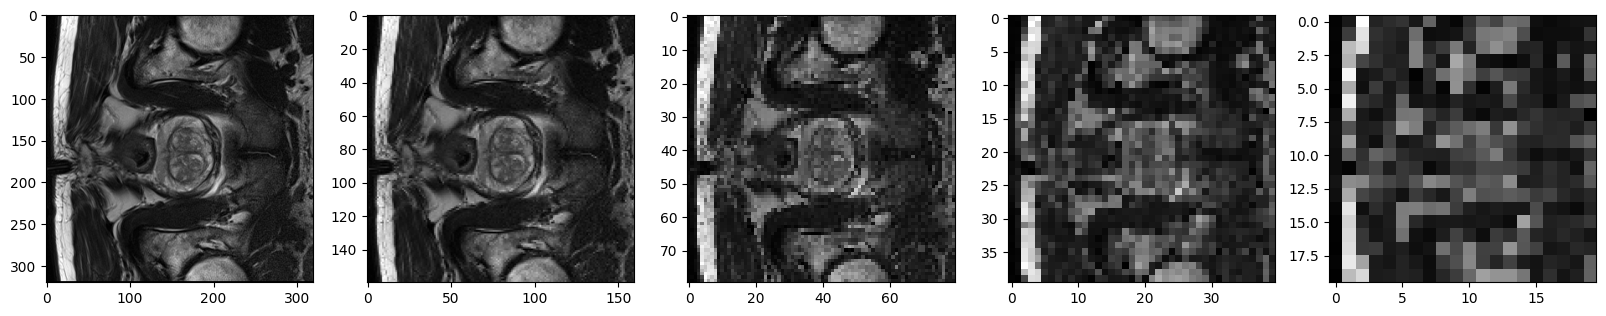

In [5]:
fig, axs = plt.subplots(1, len(lod.levels_of_detail), figsize=(20, 20))
for i, img in enumerate(lod.levels_of_detail):
    depth = img.shape[4]
    axs[i].imshow(img[0, 0, :, :, depth//2].cpu(), cmap='gray')
plt.show()

In [6]:
x[:, 1] = x[:, 0]

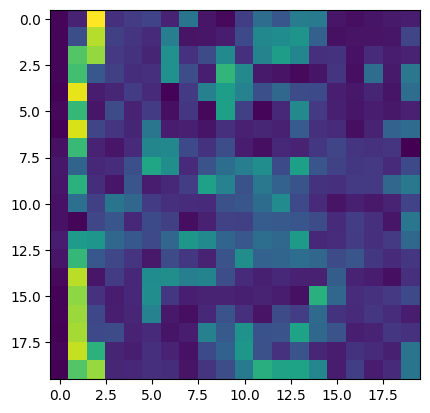

In [7]:
plt.imshow(x[0, 1, :, :, 3].cpu().detach().numpy())

In [8]:


for level in list(range(len(lod.levels_of_detail)))[::-1]: #micro to macro (low res to high res)
        x = x.permute(0, 2,3,4, 1)
        #x: BHWDC

        print(level, x[:,:,:,:,1].sum())

        #if self.separate_models:
        #    x = self.backbone_ncas[level](x, steps=self.inference_steps[level], fire_rate=self.fire_rate)
        #else:
        #    x = self.backbone_nca(x, steps=self.inference_steps[level], fire_rate=self.fire_rate)

        #x: BHWDC
        x = x.permute(0, 4, 1, 2, 3)
        # x: BCHWD

        x = x[:, self.input_channels:]

        if level > 0:
                #upscale x
                x = torch.nn.Upsample(scale_factor=tuple(self.computed_upsampling_scales[level-1][0]), 
                                        mode='nearest')(x)
                current_patch *= self.computed_upsampling_scales[level-1]
        
                #cut out patch from input_channels
                if self.patch_sizes[level-1] is not None:
                        h_start = self.my_rand_int(current_patch[0,0], current_patch[1,0] - self.patch_sizes[level-1][0])
                        w_start = self.my_rand_int(current_patch[0,1], current_patch[1,1] - self.patch_sizes[level-1][1])
                        d_start = self.my_rand_int(current_patch[0,2], current_patch[1,2] - self.patch_sizes[level-1][2])

                        x = x[:, :, 
                                h_start - current_patch[0,0]:h_start - current_patch[0,0] + self.patch_sizes[level-1][0],
                                w_start - current_patch[0,1]:w_start - current_patch[0,1] + self.patch_sizes[level-1][1],
                                d_start - current_patch[0,2]:d_start - current_patch[0,2] + self.patch_sizes[level-1][2]]
                        
                        current_patch = np.array([[h_start, w_start, d_start], 
                                                [self.patch_sizes[level-1][0] + h_start, 
                                                self.patch_sizes[level-1][1] + w_start, 
                                                self.patch_sizes[level-1][2] + d_start]
                                                ])
                
                #combine with input_channels
                input_channels = lod.levels_of_detail[level-1]
                input_channels = input_channels[:, :, 
                                                current_patch[0,0]:current_patch[1,0],
                                                current_patch[0,1]:current_patch[1,1],
                                                current_patch[0,2]:current_patch[1,2]]
                x = torch.cat([input_channels, x], dim=1)

#outputs: BHWDC

y = y[:,current_patch[0,0]:current_patch[1,0],
        current_patch[0,1]:current_patch[1,1],
        current_patch[0,2]:current_patch[1,2], :]


x = x.permute(0, 2,3,4, 1)
#x = x[..., :self.output_channels]

4 tensor(2533.8459, device='cuda:0')
3 tensor(10135.3828, device='cuda:0')
2 tensor(40541.5312, device='cuda:0')
1 tensor(324332.2500, device='cuda:0')
0 tensor(168380.7812, device='cuda:0')


In [9]:
x.shape

torch.Size([4, 160, 160, 6, 15])

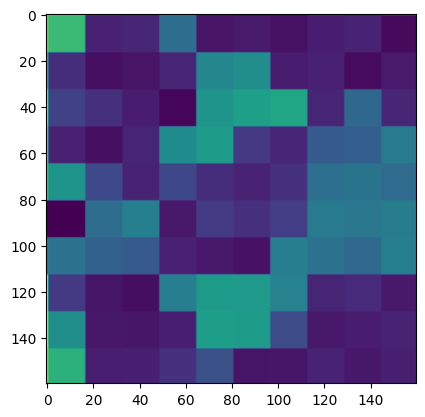

In [10]:
x.shape
plt.imshow(x[0, :, :, 3, 0].cpu().detach().numpy())

[[ 95  31   5]
 [255 191  11]]


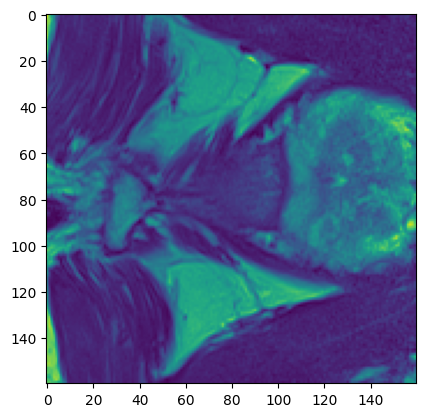

In [11]:
print(current_patch)
plt.imshow(input_channels[0, 0, :, :, 3].cpu().detach().numpy())

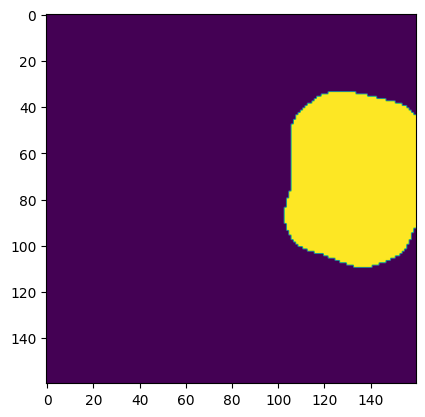

In [12]:
plt.imshow(y[0, :, :, 3, 0].cpu().detach().numpy())